# Cycle-frequency and Time-frequency comparison using synthetic EEG

---

###  Summary
- Create two differents conditions using synthetic data:
    - Cycle-locked potentials
    - Time-locked potentials
- Obtain TF maps using standard epoch segmentation (-1.5 0.5)s
- Obtain TF maps using adaptative epochs (depending on mean ttot)
- Transform time-dependent to cycle-dependent maps 
- Statistical comparison of conditions using permutation test 

----------------

Copyright (C) 2024 Xavier Navarro-Suné - All Rights Reserved

You may use, distribute and modify this code under the terms of the GNU GPL license. 

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see <http://www.gnu.org/licenses/>


## Load pacakges

In [1]:
import mne
mne.set_log_level('error')
import numpy as np
import matplotlib.pyplot as plt
import warnings
from matplotlib.colors import TwoSlopeNorm
from mne import create_info, Epochs
from mne.io import RawArray
from mne.time_frequency import tfr_morlet, tfr_array_morlet, EpochsTFR
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.stats import permutation_cluster_test
from random import gauss
#%matplotlib qt

## Setting parameters

In [2]:
# Common parameters for both generators

sfreq = 500

info = create_info(sfreq=sfreq, ch_names=['noise+burst','triggers','burst','cycles','noise'], 
                   ch_types=['eeg','stim','eeg','eeg','eeg'])

n_times1 = 210 #80 # data length for condition 1 in sec
n_times2 = 210 #80 # data length for condition 2 in sec

n_times_tot = n_times1 + n_times2

seed = 42
rng = np.random.RandomState(seed)
data = rng.randn(5, n_times_tot * sfreq)*1e-5
data[2,:] = 0

indx = np.zeros(n_times_tot * sfreq)
aperiodic_cycle = np.zeros(n_times_tot * sfreq)

# 20 Hz sinusoidal burst 
t = np.arange(n_times_tot*sfreq, dtype=np.float64) / sfreq
signal = np.sin(np.pi * 2. * 20. * t)*0.5e-5  # 20 Hz sinusoid signal

# Condition 1
mean_cycle1 = 4 # in seconds
std_cycle1 = 1
offset1 = 2

# Condition 2
mean_cycle2 = 3
std_cycle2 = 1
offset2 = 2

min_cycle_time = 2

phase_locked = False # If False, time-locked potentials are generated


## Create synthetic data with cycle-locked potentials

In [3]:
if phase_locked:
    # Cycle & Triggers settings for condition 1
    cycle_lock = 1/4 # start of time-locked event with respect cycle time
    potential_duration = 1/8 # cycle portion of potential activity
    ev_count1=0
    triggers1 = []
    cycle_times1 = []

    ev_count2=0
    triggers2 = []
    cycle_times2 = []

    end_limit = mean_cycle1 + mean_cycle2
    ti = offset1
    while ti < n_times_tot - end_limit:
        if ti < n_times1 - mean_cycle1 + std_cycle1:
            inc =  mean_cycle1 + gauss(0, 1)*std_cycle1
            if inc < min_cycle_time:
                inc = min_cycle_time + abs(gauss(0,1))
            ti = ti + inc     
            cycle_times1 = np.append(cycle_times1, inc) 
            start_potential = ti - inc*cycle_lock
            end_potential = start_potential + potential_duration*inc
            ini_samp = int(np.round(start_potential*sfreq))
            end_samp = int(np.round(end_potential*sfreq))
            data[2,ini_samp:end_samp] = np.hanning(end_samp-ini_samp)*signal[ini_samp:end_samp]       
            triggers1 = np.append(triggers1,np.round(ti*sfreq))
            ev_count1 = ev_count1 + 1
            if ev_count1 > 1:
                signal_freq = 1/cycle_times1[ev_count1-1]
                ini_r = int(triggers1[ev_count1-2])
                fin_r = int(triggers1[ev_count1-1])
                tr = np.arange(fin_r-ini_r, dtype=np.float64) / sfreq
                aperiodic_cycle[ini_r:fin_r]=np.sin(np.pi * 2. * signal_freq * tr)*1e-5 
        else:
            inc =  mean_cycle2 + gauss(0, 1)*std_cycle2
            if inc < min_cycle_time:
                inc = min_cycle_time + abs(gauss(0,1))
            ti = ti + inc
            cycle_times2 = np.append(cycle_times2, inc)
            triggers2 = np.append(triggers2,np.round(ti*sfreq))
            ev_count2 = ev_count2 + 1
            if ev_count2 == 1:
                ini_r = int(triggers1[-1])
                end_r = int(triggers2[0])
                signal_freq = int ((end_r - ini_r) / sfreq)
            else:
                ini_r = int(triggers2[ev_count2-2])
                fin_r = int(triggers2[ev_count2-1])
                signal_freq = 1/cycle_times2[ev_count2-1]
            tr = np.arange(fin_r-ini_r, dtype=np.float64) / sfreq
            aperiodic_cycle[ini_r:fin_r]=np.sin(np.pi * 2. * signal_freq * tr)*1e-5 
               
    data[4,:] = data[0,:]
    data[0,:] = data[0,:] + data[2,:]
    data[3,:] = aperiodic_cycle
    # create events array
    events = np.zeros(shape=[ev_count1+ev_count2, 3], dtype=int) 
    events[0:ev_count1,0] = triggers1
    events[0:ev_count1,2] = 1
    events[ev_count1:,0] = triggers2
    events[ev_count1:,2] = 2
  
    events.astype(int)

    raw = RawArray(data,info)
    raw.add_events(events)
    #raw.plot(events=events)
    save_key = "_cycle_locked_"


## Create synthetic data with time-locked potentials

In [4]:
if not(phase_locked):
    # Cycle & Triggers settings for condition 1
    std_potential = 0.2 # modulates latencies and duration randomly
    offset1 = 2

    latency = 0.5 # start of time-locked event with respect trigger onset (in seconds)
    potential_duration = 1/2 # ratio respect potential latency

    max_latency = 0.7
    min_latency = 0.3
    ev_count1=0
    triggers1 = []
    cycle_times1 = []

    ev_count2=0
    triggers2 = []
    cycle_times2 = []

    end_limit = mean_cycle1 + mean_cycle2
    ti = offset1
    
    while ti < n_times_tot - end_limit:
        if ti < n_times1 - mean_cycle1 + std_cycle1:
            inc =  mean_cycle1 + gauss(0, 1)*std_cycle1 # incremental randomized trigger times (sec)
            if inc < min_cycle_time:
                inc = min_cycle_time + abs(gauss(0,1))
            ti = ti + inc     
        
            cycle_times1 = np.append(cycle_times1, inc)
        
            rnd_time = gauss(0, 1)*std_potential
            rnd_pot_lat  = latency + rnd_time
            if rnd_pot_lat < min_latency:
                rnd_pot_lat = latency + abs(rnd_time/5)
            
            if rnd_pot_lat > max_latency:
                rnd_pot_lat = latency - abs(rnd_time/5)
                
            rnd_pot_dur = rnd_pot_lat*potential_duration + rnd_pot_lat/10
            
            start_potential = ti - rnd_pot_lat
            end_potential = start_potential + rnd_pot_dur
        
            ini_samp = int(np.round(start_potential*sfreq))
            end_samp = int(np.round(end_potential*sfreq))
        
            #print("ti=", ti, " inc=", inc, " start_p=", start_potential, " end_p=", end_potential)
            #print("    dur_pot=", rnd_pot_dur, "latency=", rnd_pot_lat)
            #print("    rnd_time = ", rnd_time)
            
            data[2,ini_samp:end_samp] = np.hanning(end_samp-ini_samp)*signal[ini_samp:end_samp]       
            triggers1 = np.append(triggers1,np.round(ti*sfreq))
            ev_count1 = ev_count1 + 1
            if ev_count1 > 1:
                signal_freq = 1/cycle_times1[ev_count1-1]
                ini_r = int(triggers1[ev_count1-2])
                fin_r = int(triggers1[ev_count1-1])
                tr = np.arange(fin_r-ini_r, dtype=np.float64) / sfreq
                aperiodic_cycle[ini_r:fin_r]=np.sin(np.pi * 2. * signal_freq * tr)*1e-5 
        else:
            inc =  mean_cycle2 + gauss(0, 1)*std_cycle2
            if inc < min_cycle_time:
                inc = min_cycle_time + abs(gauss(0,1))
            #print("inc=", inc)
            ti = ti + inc
            cycle_times2 = np.append(cycle_times2, inc)
            triggers2 = np.append(triggers2,np.round(ti*sfreq))
            ev_count2 = ev_count2 + 1
            if ev_count2 == 1:
                ini_r = int(triggers1[-1])
                end_r = int(triggers2[0])
                signal_freq = int ((end_r - ini_r) / sfreq)
            else:
                ini_r = int(triggers2[ev_count2-2])
                fin_r = int(triggers2[ev_count2-1])
                signal_freq = 1/cycle_times2[ev_count2-1]
            tr = np.arange(fin_r-ini_r, dtype=np.float64) / sfreq
            aperiodic_cycle[ini_r:fin_r]=np.sin(np.pi * 2. * signal_freq * tr)*1e-5 
               
    data[4,:] = data[0,:]
    data[0,:] = data[0,:] + data[2,:]
    data[3,:] = aperiodic_cycle
    # create events array
    events = np.zeros(shape=[ev_count1+ev_count2, 3], dtype=int) 
    events[0:ev_count1,0] = triggers1
    events[0:ev_count1,2] = 1
    events[ev_count1:,0] = triggers2
    events[ev_count1:,2] = 2
  
    events.astype(int)

    raw = RawArray(data,info)
    raw.add_events(events)
    #raw.plot(events=events)
    save_key = "_time_locked_"


## Segmentation parameters

In [5]:
# Fixed segmentation

tmin_f = -1.5
tmax_f = 0.5
baseline_f = (tmin_f, tmin_f+0.5)

# Adaptive segmentation

# Define epochs based on mean duration of cycle (seconds)
ttot1 = np.mean(cycle_times1)
ttot2 = np.mean(cycle_times2)

ini_phase = -1/2  # relative to an entire cycle (1/2 = 180°)
end_phase = 1/4   

tmin_a1 = ttot1*ini_phase # consideration: simmetrical cycle 
tmax_a1 = ttot1*end_phase

tmin_a2 = ttot2*ini_phase 
tmax_a2 = ttot2*end_phase


## Create epochs

In [6]:
# Condition 1 
event_id = 1
# conventional segmentation
epochs_x = Epochs(raw, events, event_id, tmin=tmin_f, tmax=tmax_f, baseline=None)

# Segmentation adapted to mean duration of breaths
epochs_z = Epochs(raw, events, event_id, tmin=tmin_a1, tmax=tmax_a1, baseline=None)

# Condition 2, if a different contrast condition is needed
#event_id = 2
#epochs_x2 = Epochs(raw, events, event_id, tmin=tmin_f, tmax=tmax_f, baseline=None)
#epochs_z2 = Epochs(raw, events, event_id, tmin=tmin_a2, tmax=tmax_a2, baseline=None)

n = epochs_x.events.shape[0]
print("Number of trials : ", n)

Number of trials :  50


## TFR analysis

In [7]:
# TFR parameters
decim = 1
freqs = np.arange(5, 30, 0.5)  # define frequencies of interest
n_cycles = freqs/2

In [8]:
# Run TFR decomposition

# Fixed segmentation
tfr_epochs_x = tfr_morlet(epochs_x, freqs, n_cycles=n_cycles,return_itc=False, average=False, output='complex')

# Adaptive segmentation
tfr_epochs_z = tfr_morlet(epochs_z, freqs, n_cycles=n_cycles,return_itc=False, average=False, output='complex')


## Time-phase conversion

In [9]:
# Time-phase parameters
ph_step = 1      # phase resolution ; Minimal value = 1 (recommended)
verbose = False  # show progress bar and other informations during transformation
min_ttot = 1.5  # minimal breath duration to perform TFR
max_ttot = min_ttot*6
segmentation = 0 # set to 0 for cycle length adapted segmentation

In [10]:
# Prepare data for statistical tests 

tfr_x = tfr_epochs_x.data[:, 0:1, :, :] 
tfr_x_ctr = tfr_epochs_x.data[:, 3:4, :, :] 

tfr_z = tfr_epochs_z.data[:, 0:1, :, :]
tfr_z_ctr = tfr_epochs_z.data[:, 3:4, :, :]

# Different time arrays for plotting
times = 1e3 * tfr_epochs_x.times  # change unit to ms
times_a1 = 1e3 * tfr_epochs_z.times 
times_rescaled = np.arange(tmin_f,tmax_f,2/270)

#### Convert complex TFRs to cycle domain 

In [11]:
from CFA_functions import time_to_phase_average, time_to_phase_by_cycle, compute_itc_pfr, apply_baseline_CF_map

# Mean adaptive segmentation
pfr_z, phases1 = time_to_phase_average(tfr_z, times_a1, ph_step, ini_phase, end_phase, verbose)

pfr_z_ctr, phases1 = time_to_phase_average(tfr_z_ctr, times_a1, ph_step, ini_phase, end_phase, verbose)


# Cycle-by-cycle segmentation
pfr_y, phases = time_to_phase_by_cycle(data[0,:],sfreq, triggers1,1, ini_phase, 
                                    end_phase, freqs, n_cycles, min_ttot, max_ttot, segmentation,  verbose)

pfr_y_ctr, phases = time_to_phase_by_cycle(data[4,:],sfreq, triggers1,1, ini_phase, 
                                    end_phase, freqs, n_cycles, min_ttot, max_ttot, segmentation, verbose)

# Change x resolution of TF maps with fixed segmentation, to facilitate visual comparaision
tfr_x_dwn, tms = time_to_phase_average(tfr_x, times, ph_step, ini_phase, end_phase, verbose)
tfr_x_dwn_ctr, tms = time_to_phase_average(tfr_x_ctr, times, ph_step, ini_phase, end_phase, verbose)


### Prepare data for plotting

In [12]:
# ---------------- Apply baseline --------------------------
baseline_type = 1 # 0: baseline subtraction ; 1: Relative changes
ind1 = 0
ind2 = round(phases.size*0.15)

pow_x_dwn_ =  np.abs(tfr_x_dwn)
pow_x_dwn = apply_baseline_CF_map(pow_x_dwn_, ind1, ind2, baseline_type)

pow_z_ = np.abs(pfr_z)
pow_z  = apply_baseline_CF_map(pow_z_, ind1, ind2, baseline_type)

pow_y_ = np.abs(pfr_y)
pow_y  = apply_baseline_CF_map(pow_y_, ind1, ind2, baseline_type)

# -------- Average maps to obtain power and ITC
avg_pow_x_dwn = pow_x_dwn.mean(axis=(0))
itc_x_dwn =  compute_itc_pfr(tfr_x_dwn)

avg_pow_z = pow_z.mean(axis=(0))
itc_z = compute_itc_pfr(pfr_z)

avg_pow_y = pow_y.mean(axis=(0))
itc_y = compute_itc_pfr(pfr_y)


# Create matrix of images for plotting
img = np.stack([avg_pow_x_dwn[0,:,:], itc_x_dwn[0,:,:],
               avg_pow_z[0,:,:], itc_z[0,:,:],
               avg_pow_y[0,:,:],itc_y[0,:,:]
               ])

x_vals   = np.array([[times_rescaled[0], times_rescaled[-1]],[phases[0], phases[-1]], [phases[0], phases[-1]]])


In [13]:
# Set plotting parameters
max_P = np.array([np.nanmax(img[[0,2,4],:,:])*1.25, 1])
min_P = np.array([np.nanmin(img[[0,2,4],:,:]), 0])*2

cmap_P = 'jet'  

# Axis and ticks

xtick_vals  = np.array([
                       [-1.5, -1,  -0.5, -0.25, 0, 0.25, 0.5],
                       [-180, -135, -90, -45,   0, 45,   90],
                       [-180, -135, -90, -45,   0, 45,   90]
                       ])
                       

xtick_labels = np.array([
                        ['-1.5',  '-1', '-0.5',   ' ',  '0', ' ', '0.5'],
                        ['-π', '-3π/4', '-π/2', '-π/4', '0','π/4', 'π/2'],
                        ['-π', '-3π/4', '-π/2', '-π/4', '0','π/4', 'π/2']
                        ])

xlabels = np.array([ 
                    'Time (s)','Time (s)', 
                    'Phase (rad)', 'Phase (rad)', 
                    'Phase (rad)', 'Phase (rad)'
                   ])

clabels = np.array(['Power', 'ITC'])

# Text settings
text_kwargs = dict(ha='center', va='center', fontsize=18, color='k')
x_txt = [0.085, 0.535]
y_txt = [0.87, 0.59, 0.30]
txts  = ['A1','A2','B1','B2','C1','C2']


### Comparison of maps

#### Plot both Power & ITC 

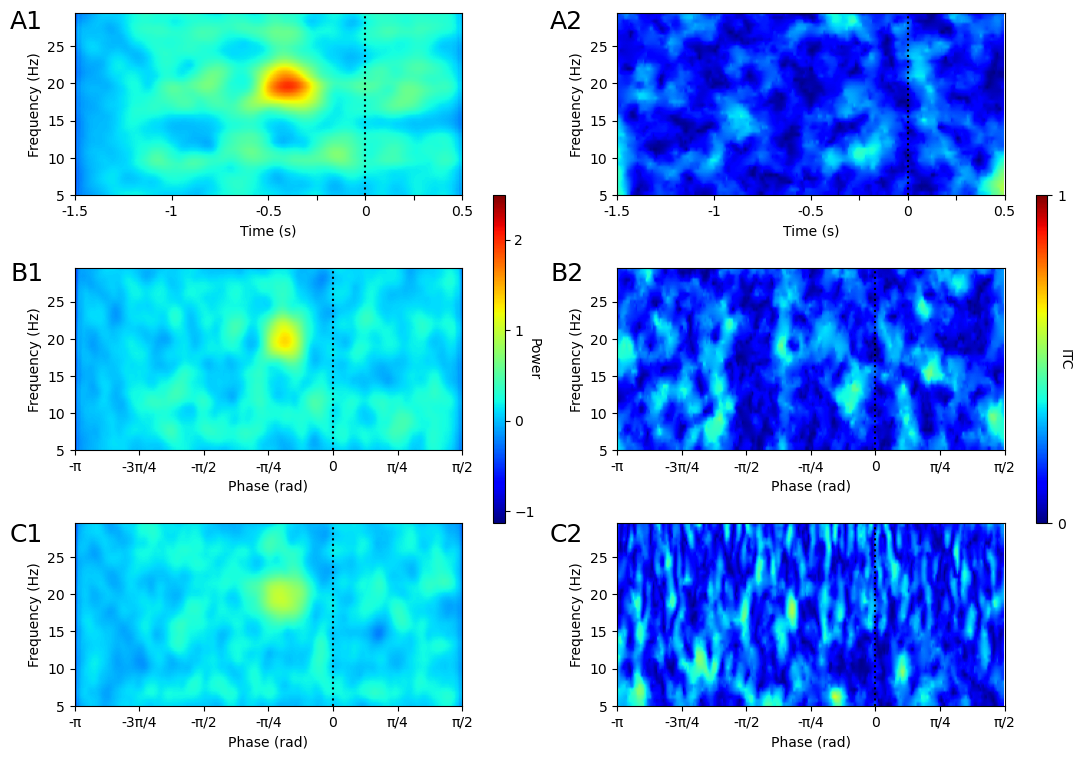

In [ ]:
# Show figure with power and itc
#fname1 = 'pow_itc_maps_synthetic_n' + save_key + str(n) + '.pdf'
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
c=0
for row in range(3):
    for col in range(2):
        ax = axs[row, col]
        pcm=ax.imshow(img[c,:,:],extent=[x_vals[row,0], x_vals[row,1], freqs[0], freqs[-1]],
            aspect='auto', origin='lower', cmap=cmap_P, vmin=min_P[col], vmax=max_P[col])
        ax.set_xlabel(xlabels[c])
        ax.set_ylabel('Frequency (Hz)')
        ax.axvline(x = 0, color = 'k', linestyle='dotted')
        fig.text(x_txt[col], y_txt[row], txts[c], **text_kwargs)
        c=c+1
        if row==2:
            cax = ax.inset_axes([1.08, 1, 0.03, 1.8])
            cbar = fig.colorbar(pcm, ax=axs[:, col], ticks=[-1, 0, 1, 2], cax=cax, shrink=0.6)
            cbar.set_label(clabels[col], rotation=270, size='10')
        ax.set_xticks(xtick_vals[row,:], xtick_labels[row,:], color='k')
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    

plt.show()
#fig.savefig(fname1,format='pdf')

## Non-parametric between conditions cluster statistic on single trial power
In this test, condition 1 and condition 2 will be compared. No baseline correction needs to be done

In [15]:
# Permutation test parameters
from CFA_functions import permutation_test_plot

#threshold = 6
n_permutations = 500
alpha  = 0.01
cmap_F = 'jet'
right_exclude = 10 # Number of leftmost samples to be excluded to avoid edge effects
left_exclude = 10   # Number of rightmost samples to be excluded
baseline = np.array([ind1, ind2])
threshold = dict(start=0, step=0.5) # threshold_tfce
contours = False  # compute contours of significant areas (not necessary here)

In [16]:
F_obs1, F_obs_plot1, cnt  = permutation_test_plot(pow_x_dwn_, np.abs(tfr_x_dwn_ctr), times_rescaled, freqs, threshold, 
                      n_permutations, left_exclude, right_exclude, alpha, contours)

In [17]:
# Run tests for average cycle segmentation
F_obs2, F_obs_plot2, cnt = permutation_test_plot(pow_z_, np.abs(pfr_z_ctr), phases, freqs, threshold, 
                      n_permutations, left_exclude, right_exclude, alpha, contours)

In [18]:
# Tests for cycle-by-cycle segmentation
F_obs3, F_obs_plot3, cnt  = permutation_test_plot(pow_y_, np.abs(pfr_y_ctr), phases, freqs, threshold, 
                      n_permutations, left_exclude, right_exclude, alpha, contours)

In [19]:
# Prepare data for plotting

F_obs = [F_obs1[0,:,:], F_obs2[0,:,:], F_obs3[0,:,:]]
F_obs_plot = [F_obs_plot1[0,:,:], F_obs_plot2[0,:,:], F_obs_plot3[0,:,:]]

# Compute mask to find contours of significant areas
F_contour1 = (F_obs_plot1[0,:,:]*0)+1
F_contour2 = (F_obs_plot2[0,:,:]*0)+1
F_contour3 = (F_obs_plot3[0,:,:]*0)+1

F_contour1[np.isnan(F_contour1)] = 0
F_contour2[np.isnan(F_contour2)] = 0
F_contour3[np.isnan(F_contour3)] = 0
    
F_contour = [F_contour1, F_contour2, F_contour3]

mx = np.array([ np.nanmax(abs(F_obs_plot1[:,:-2])),
                np.nanmax(abs(F_obs_plot2[:,:-2])), 
                np.nanmax(abs(F_obs_plot3[:,:-2]))
                          ])
                           
mn = np.array([ np.nanmin(abs(F_obs_plot1[:,:-2])),
                np.nanmin(abs(F_obs_plot2[:,:-2])), 
                np.nanmin(abs(F_obs_plot3[:,:-2]))
                          ])    

# Max value accross tests, avoiding extreme values, possibly influenced by imprecisions during conversion
max_F = np.nanmax([abs(F_obs1[:,:-2]), abs(F_obs2[:,:-2]), abs(F_obs3[:,:-2])])
min_F = np.nanmin([abs(F_obs1[:,:-2]), abs(F_obs2[:,:-2]), abs(F_obs3[:,:-2])])
#min_F = -max_F/4

txts2 = ['A','B','C']
xres  = np.array([140, 1, 1]) 


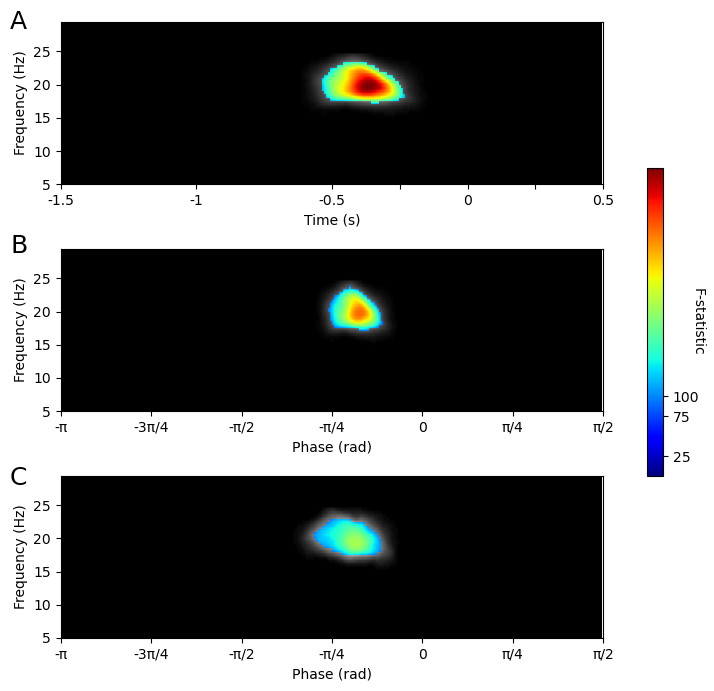

In [20]:
from skimage import measure

fname2 = 'TF_CF_stats_synthetic' + save_key + '.pdf'
fig, axs = plt.subplots(3, 1, figsize=(7, 8))
cnt=0

for row in range(3):
    ax = axs[row]
    ax.imshow(F_obs[row],extent=[x_vals[row,0], x_vals[row,1], freqs[0], freqs[-1]],aspect='auto', origin='lower', cmap='gray')
    mp = ax.imshow(F_obs_plot[row],extent=[x_vals[row,0], x_vals[row,1], freqs[0], freqs[-1]],
              aspect='auto', origin='lower', cmap=cmap_F, vmin=min_F, vmax=max_F)
    ax.set_xlabel(xlabels[row+cnt])
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xticks(xtick_vals[row,:], xtick_labels[row,:], color='k')
    fig.text(x_txt[0]-0.02, y_txt[row]+0.01, txts2[row], **text_kwargs)
    cnt=cnt+1
    
fig.subplots_adjust(hspace=0.4, wspace=0.4)
cax = ax.inset_axes([1.08, 1, 0.03, 1.9])
cbar = fig.colorbar(mp, ax=ax, ticks=[25, 75, 100], cax=cax, shrink=0.6)
cbar.set_label('F-statistic', rotation=270, size='10')
plt.show()
#fig.savefig(fname2,format='pdf')


### Plot only power with statistically significant areas

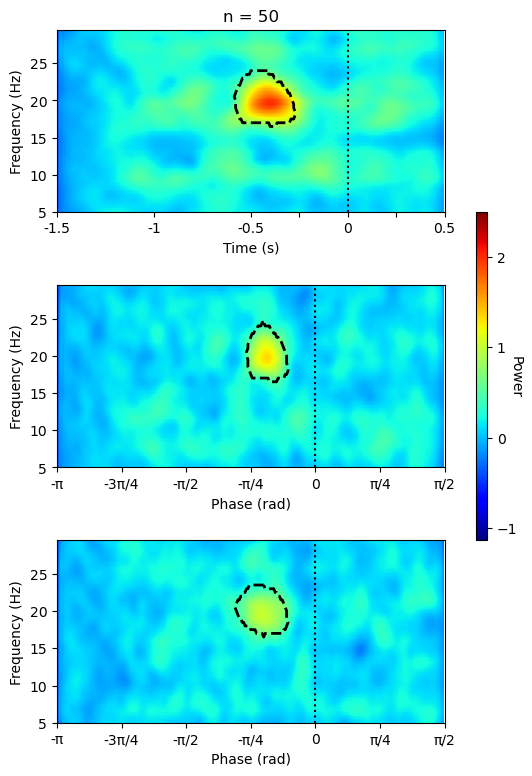

In [21]:
#fname2 = 'pow_maps_synthetic_n' + save_key + str(n) + '.pdf'

fig2, axs2 = plt.subplots(3, 1, figsize=(5, 9))
c=0
for row in range(3):
    ax = axs2[row]
    pcm=ax.imshow(img[c,:,:],extent=[x_vals[row,0], x_vals[row,1], freqs[0], freqs[-1]],
        aspect='auto', origin='lower', cmap=cmap_P, vmin=min_P[0], vmax=max_P[0])
    ax.set_xlabel(xlabels[c])
    ax.set_ylabel('Frequency (Hz)')
    ax.axvline(x = 0, color = 'k', linestyle='dotted')
    #fig2.text(x_txt[0], y_txt[row], txts[c], **text_kwargs)
    c=c+2
    contours = measure.find_contours(F_contour[row],level=0, fully_connected='low')
    for contour in contours:
        ax.plot((contour[:, 1]+x_vals[row,0]*xres[row])/xres[row], (contour[:, 0]+freqs[0]*2)/2, 
                linewidth=2, color='k', linestyle='--')
    if row==0:
        ax.set_title('n = '+str(n))
    if row==2:
        cax = ax.inset_axes([1.08, 1, 0.03, 1.8])
        cbar = fig.colorbar(pcm, ax=axs2[:], ticks=[-1, 0, 1, 2], cax=cax, shrink=0.6)
        cbar.set_label(clabels[0], rotation=270, size='10')
    ax.set_xticks(xtick_vals[row,:], xtick_labels[row,:], color='k')
fig2.subplots_adjust(hspace=0.4, wspace=0.8)    

plt.show()
#fig2.savefig(fname2,format='pdf')